In [1]:
import sys
sys.path.insert(0, '..')
from AttentionModule import Conv2d_Attn

import torch
from torch import nn
from torchvision import models, datasets, transforms
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

import re
import copy
import numpy as np

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
resnet_pretrained = models.resnet50(pretrained=True)
resnet_attn = torch.load('l1-norm-top3-67-per-filt.pkl')

In [3]:
conv1_weights = resnet_attn.conv1.attn_weights.data.squeeze().cpu().numpy()

In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose(
    [transforms.ToTensor(),
     normalize])

In [5]:
params = (resnet_attn.conv1.bias, 
         resnet_attn.conv1.stride, 
         resnet_attn.conv1.padding, 
         resnet_attn.conv1.dilation, 
         resnet_attn.conv1.groups)

In [6]:
resnet_pretrained = resnet_pretrained.cuda()

In [7]:
sample_weight = resnet_pretrained.conv1.weight[[0],:]

In [8]:
def preprocess_image(cv2im, resize_im=False):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): Image to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (Pytorch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # Resize image
#     if resize_im:
#         cv2im = cv2.resize(cv2im, (224, 224))
    im_as_arr = np.float32(cv2im)
    im_as_arr = np.ascontiguousarray(im_as_arr[..., ::-1])
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var

def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    # Convert RBG to GBR
    recreated_im = recreated_im[..., ::-1]
    return recreated_im

In [14]:
resnet_pretrained.conv1.weight.shape

torch.Size([64, 3, 7, 7])

In [63]:
filter_acts = []
for i in range(64):
    sample_weight = resnet_pretrained.conv1.weight[[i],:]

    rand_im = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
    start_im = preprocess_image(rand_im)
    start_im = Variable(start_im.data.cuda(), requires_grad=True)
    optimizer = optim.SGD([start_im], lr=5)
    for _ in range(1, 50):
        optimizer.zero_grad()
        loss = -torch.nn.functional.conv2d(start_im, sample_weight, *params).norm()
        loss.backward()
        optimizer.step()

    end_im = recreate_image(start_im.cpu())
    filter_acts.append(end_im)

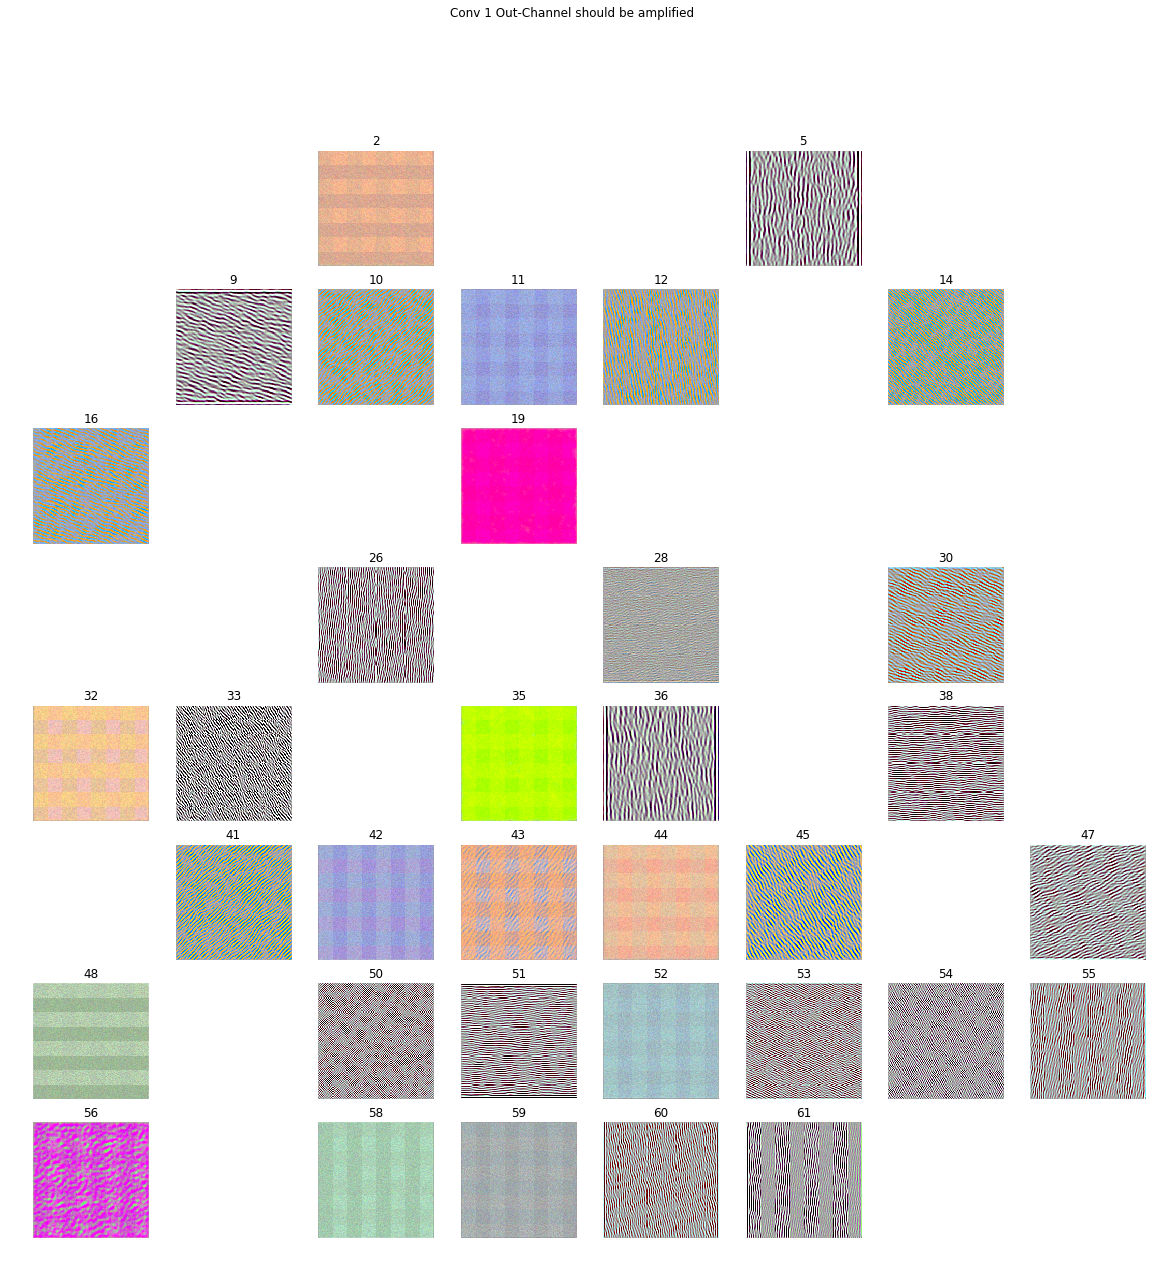

In [68]:
plt.figure(figsize=(20,20))
plt.suptitle("Conv 1 Out-Channel should be amplified")
for i in range(64):
    if beneficial[i]:
        plt.subplot(8,8,i+1)
        plt.imshow(filter_acts[i])
        plt.axis('off')
        plt.title(str(i))
plt.savefig('../imgs/amp.png')

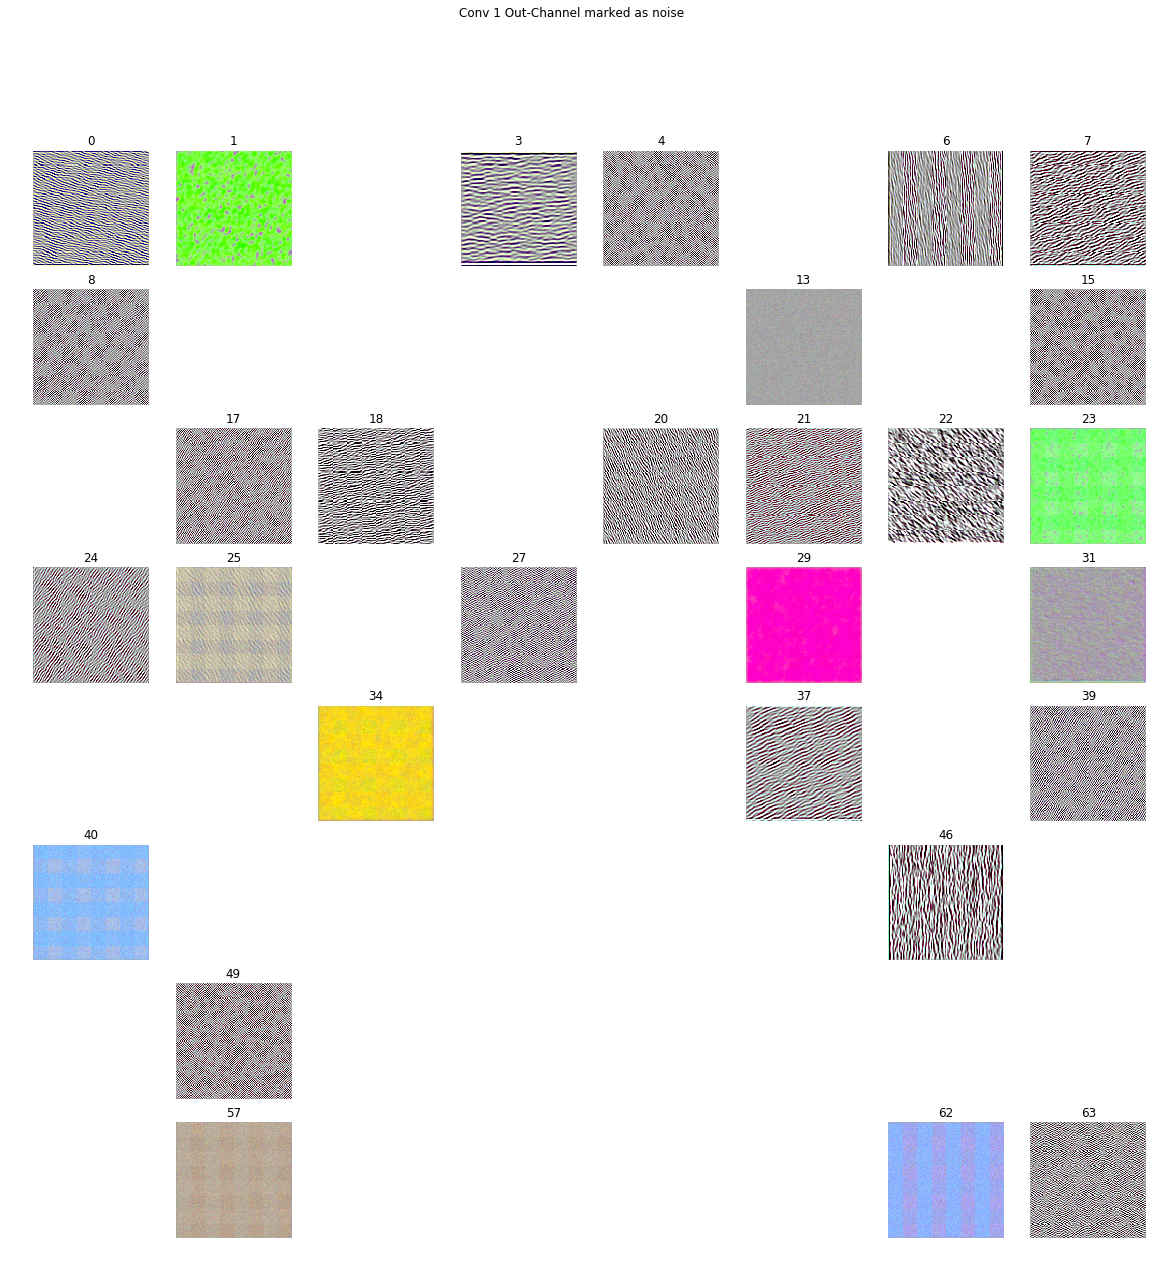

In [69]:
plt.figure(figsize=(20,20))
plt.suptitle("Conv 1 Out-Channel marked as noise")
for i in range(64):
    if not beneficial[i]:
        plt.subplot(8,8,i+1)
        plt.imshow(filter_acts[i])
        plt.axis('off')
        plt.title(str(i))
plt.savefig('../imgs/noise.png')

In [52]:
resnet_attn = torch.load('l1-norm-top3-67.pkl')

In [58]:
attns_conv1 = resnet_attn.conv1.attn_weights.squeeze().data.cpu().numpy()

In [61]:
beneficial = attns_conv1 > 1

In [87]:
good = np.argwhere(beneficial).flatten()
bad = np.argwhere(1-beneficial).flatten()

In [88]:
np.random.shuffle(good)

In [89]:
np.random.shuffle(bad)

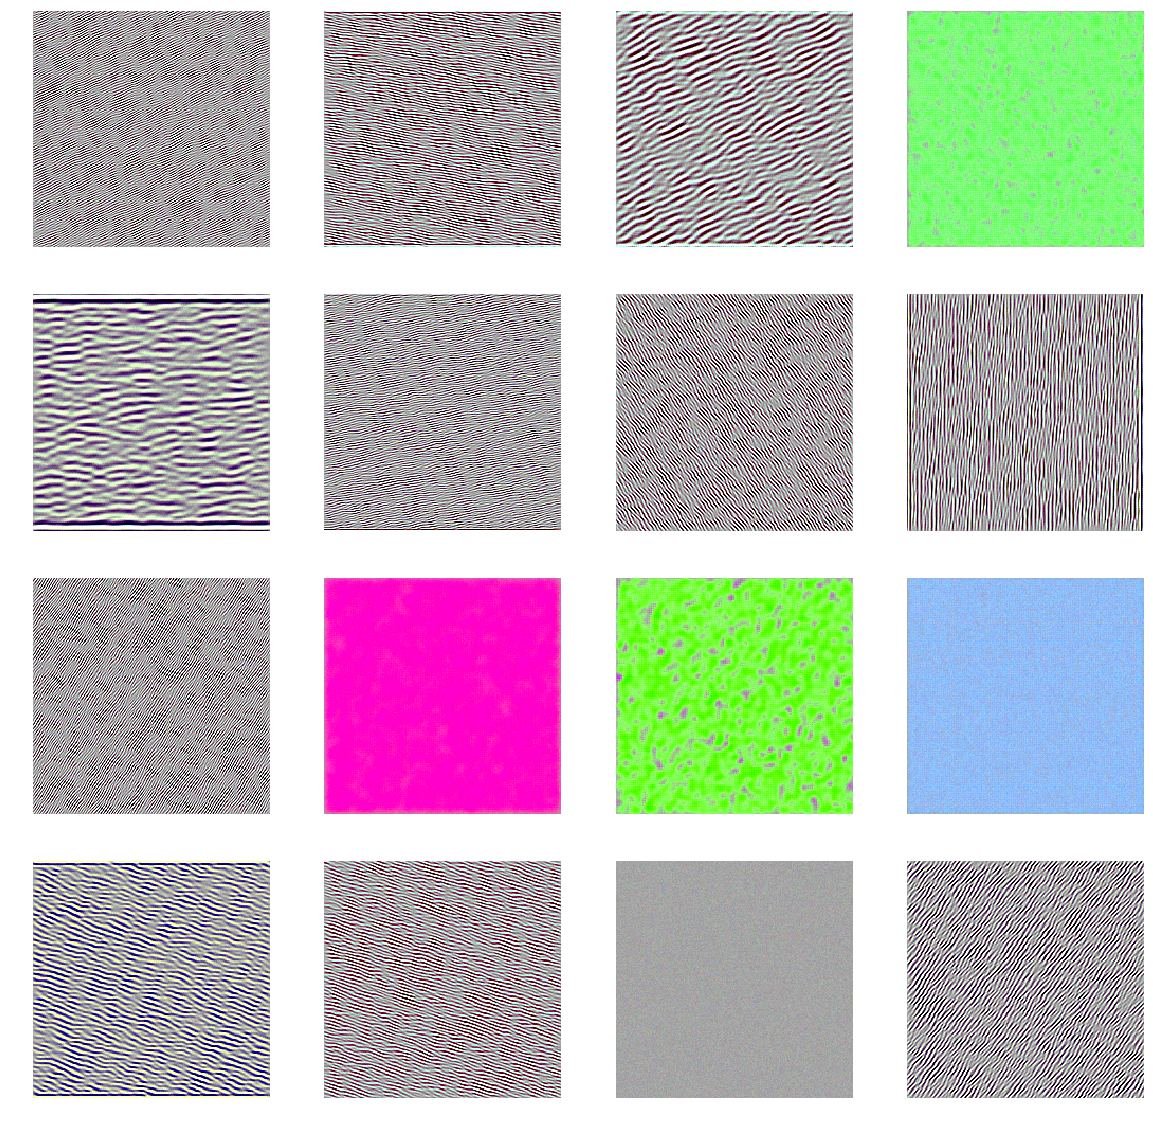

In [90]:
plt.figure(figsize=(20,20))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(filter_acts[bad[i]])
    plt.axis('off')
plt.savefig('../imgs/noise.png')

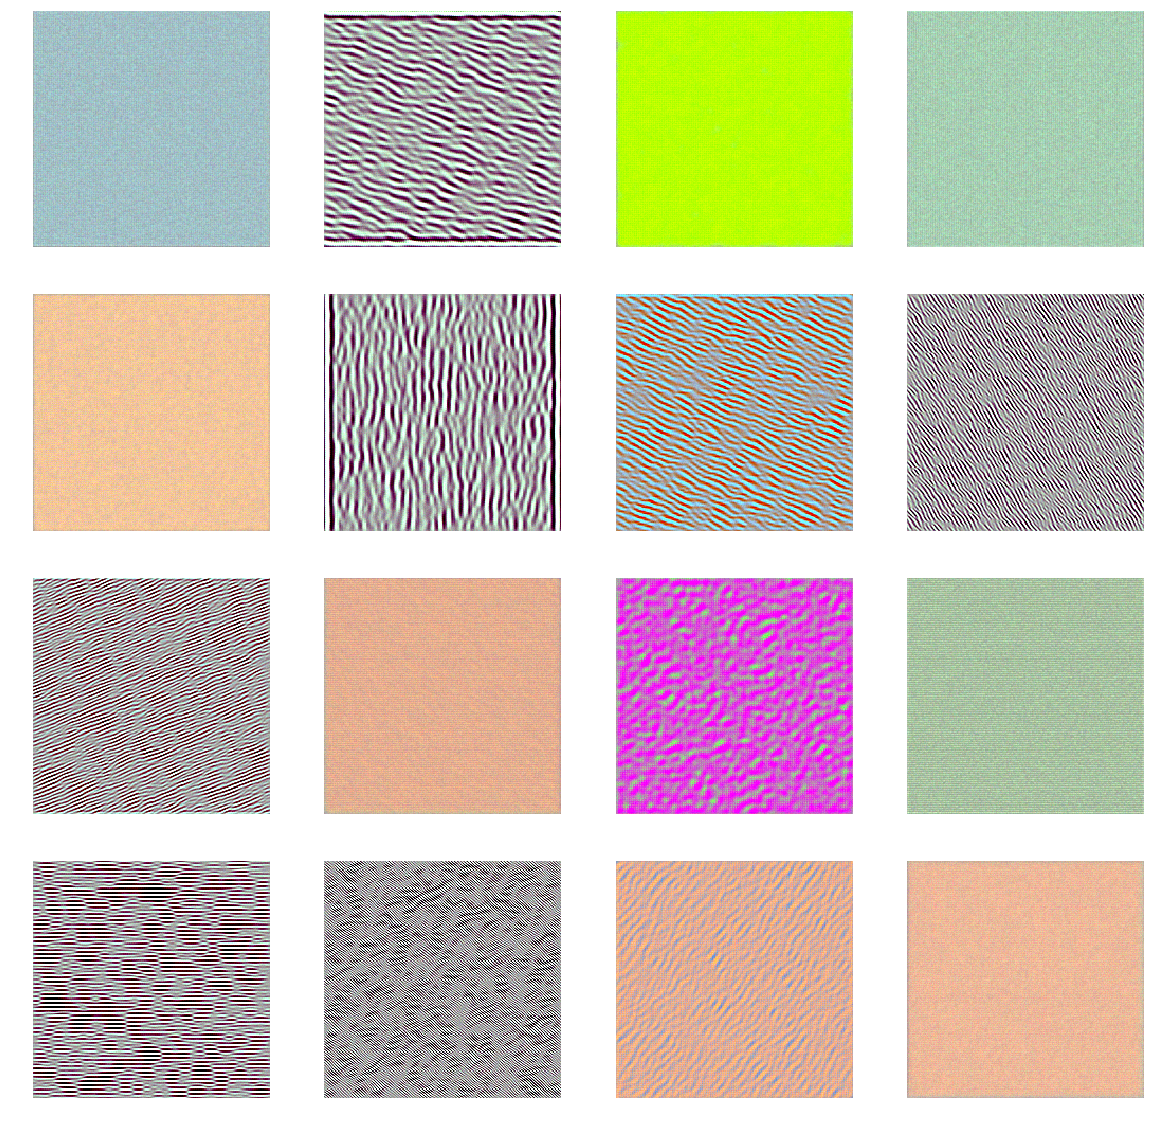

In [91]:
plt.figure(figsize=(20,20))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(filter_acts[good[i]])
    plt.axis('off')
plt.savefig('../imgs/amp.png')